In [1]:
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
from ATL11.RDE import RDE
import scipy.interpolate as si
import scipy.stats as ss
import h5py
import os
import re
import matplotlib.gridspec as gridspec
import pandas as pd
data_root = '/Volumes/ice2/ben/MAR/ATL11_with_corrections/'

In [2]:
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_sigma_lt_20.tif')
v_mask.index(np.arange(0, v_mask.shape[0], 5), np.arange(0, v_mask.shape[1], 5));
dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')

## read in the data file.  
The data were written by the 'reduce_firn_dh' notebook.  It contains one top-level group for each model, and beneath that, one group for each epoch.  Within each epoch, the data represent a 2.5-km blockmedian of the corrected elevation-change values.  This gives a smaller number of difference values for each region, and makes a file of reasonable size.

Applying the blockmedian to the drainage basin variable didn't work well (cells containing borders aren't represented well), so let's repeat the interpolation for the cell locations.

In [3]:
data_file=os.path.join(data_root+'/combined_xover_at_differences.h5')


strings_xover = ['2018.Q4-2019.Q2','2019.Q1-2019.Q2']
strings_at=['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
epochs=strings_xover+strings_at

D={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D[model]={}
    for epoch in epochs:
        this_group='/'.join(['',model, epoch])
        D[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D[model][epoch].assign({'basin':np.floor(dbi.__call__((D[model][epoch].y, D[model][epoch].x))*10)/10})

['GSFC_fdm_v1_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_ERA_10km_zsurf_ave', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_zsurf_ave', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_zsurf_ave', 'MARv3_11_ERA_zsurf']


## Maps of differences.
Let's do a quick map of the elevation differences for the ice cap.

<IPython.core.display.Javascript object>


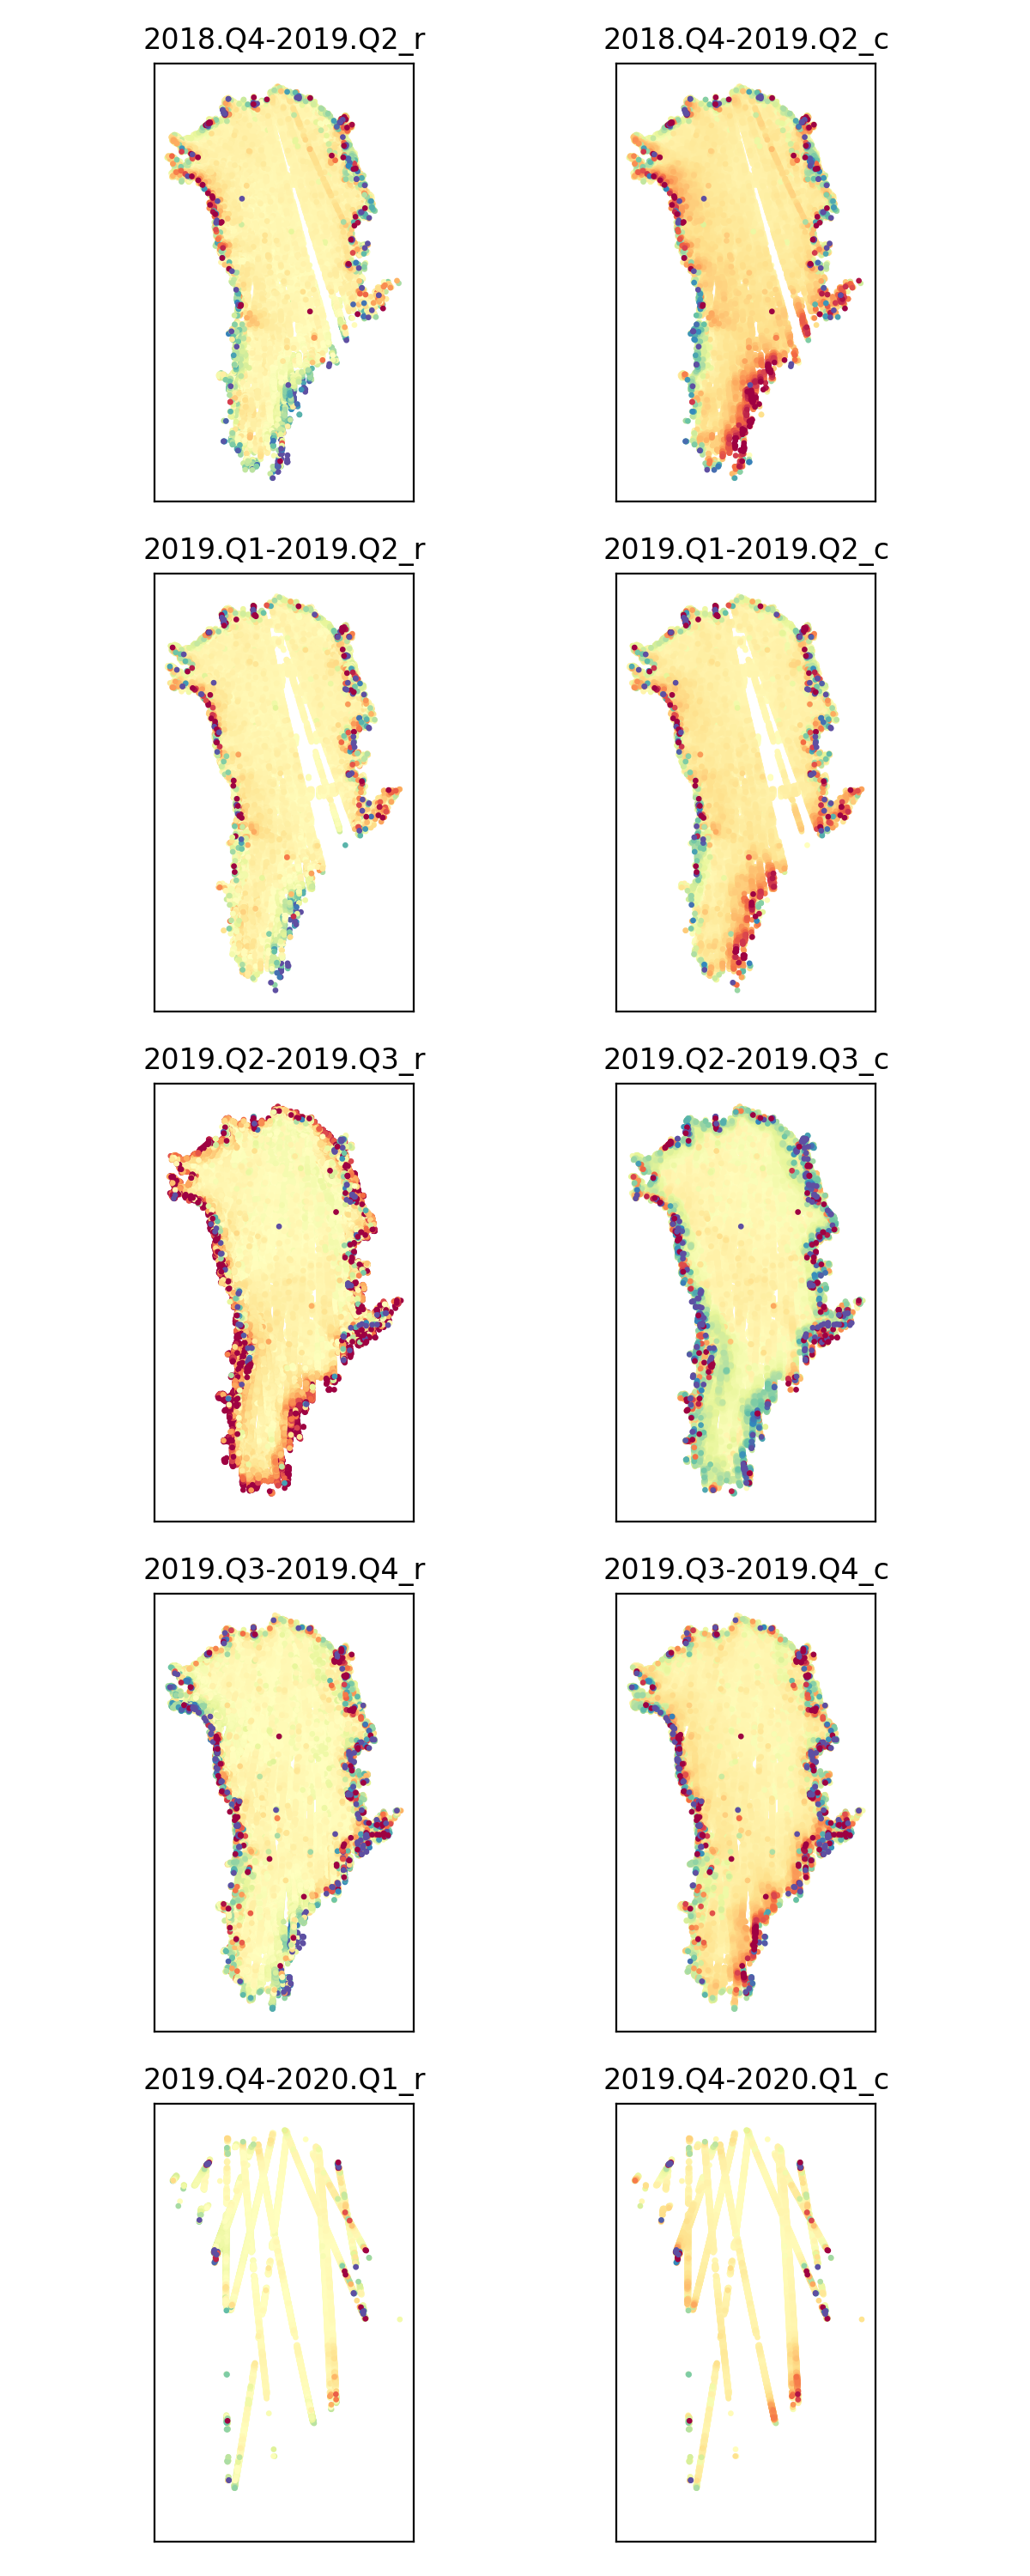

In [4]:
strings=strings_xover+strings_at
model='MARv3_11_2_ERA_10km_zsurf'

fig=plt.figure(3, figsize=[6, 15])
fig.clf()
n_plots=5
hax=[[fig.add_subplot(n_plots, 2, 1, aspect='equal')]]
for epoch_n in range(n_plots):
    if epoch_n > 0:
        hax.append([])
    for ii in [0, 1]:
        if ii > 0 or epoch_n > 0:
            hax[epoch_n].append(fig.add_subplot(n_plots, 2, 2*epoch_n+ii+1, \
                                            sharex=hax[0][0], sharey=hax[0][0],\
                                           aspect='equal'))
for count, epoch in enumerate(epochs):
    temp=D[model][epoch]
    # raw data
    this_ax=hax[count][0]
    ind=np.argsort(np.abs(temp.dh_corr))
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_r')
    #corrected data:
    this_ax=hax[count][1]
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh_corr[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_c')
    this_ax.set_xticks([])
    this_ax.set_yticks([])
plt.tight_layout()

### Histograms of data

In these plots we'll look at the histograms of elevaiton differences for a particular epoch and model

<IPython.core.display.Javascript object>


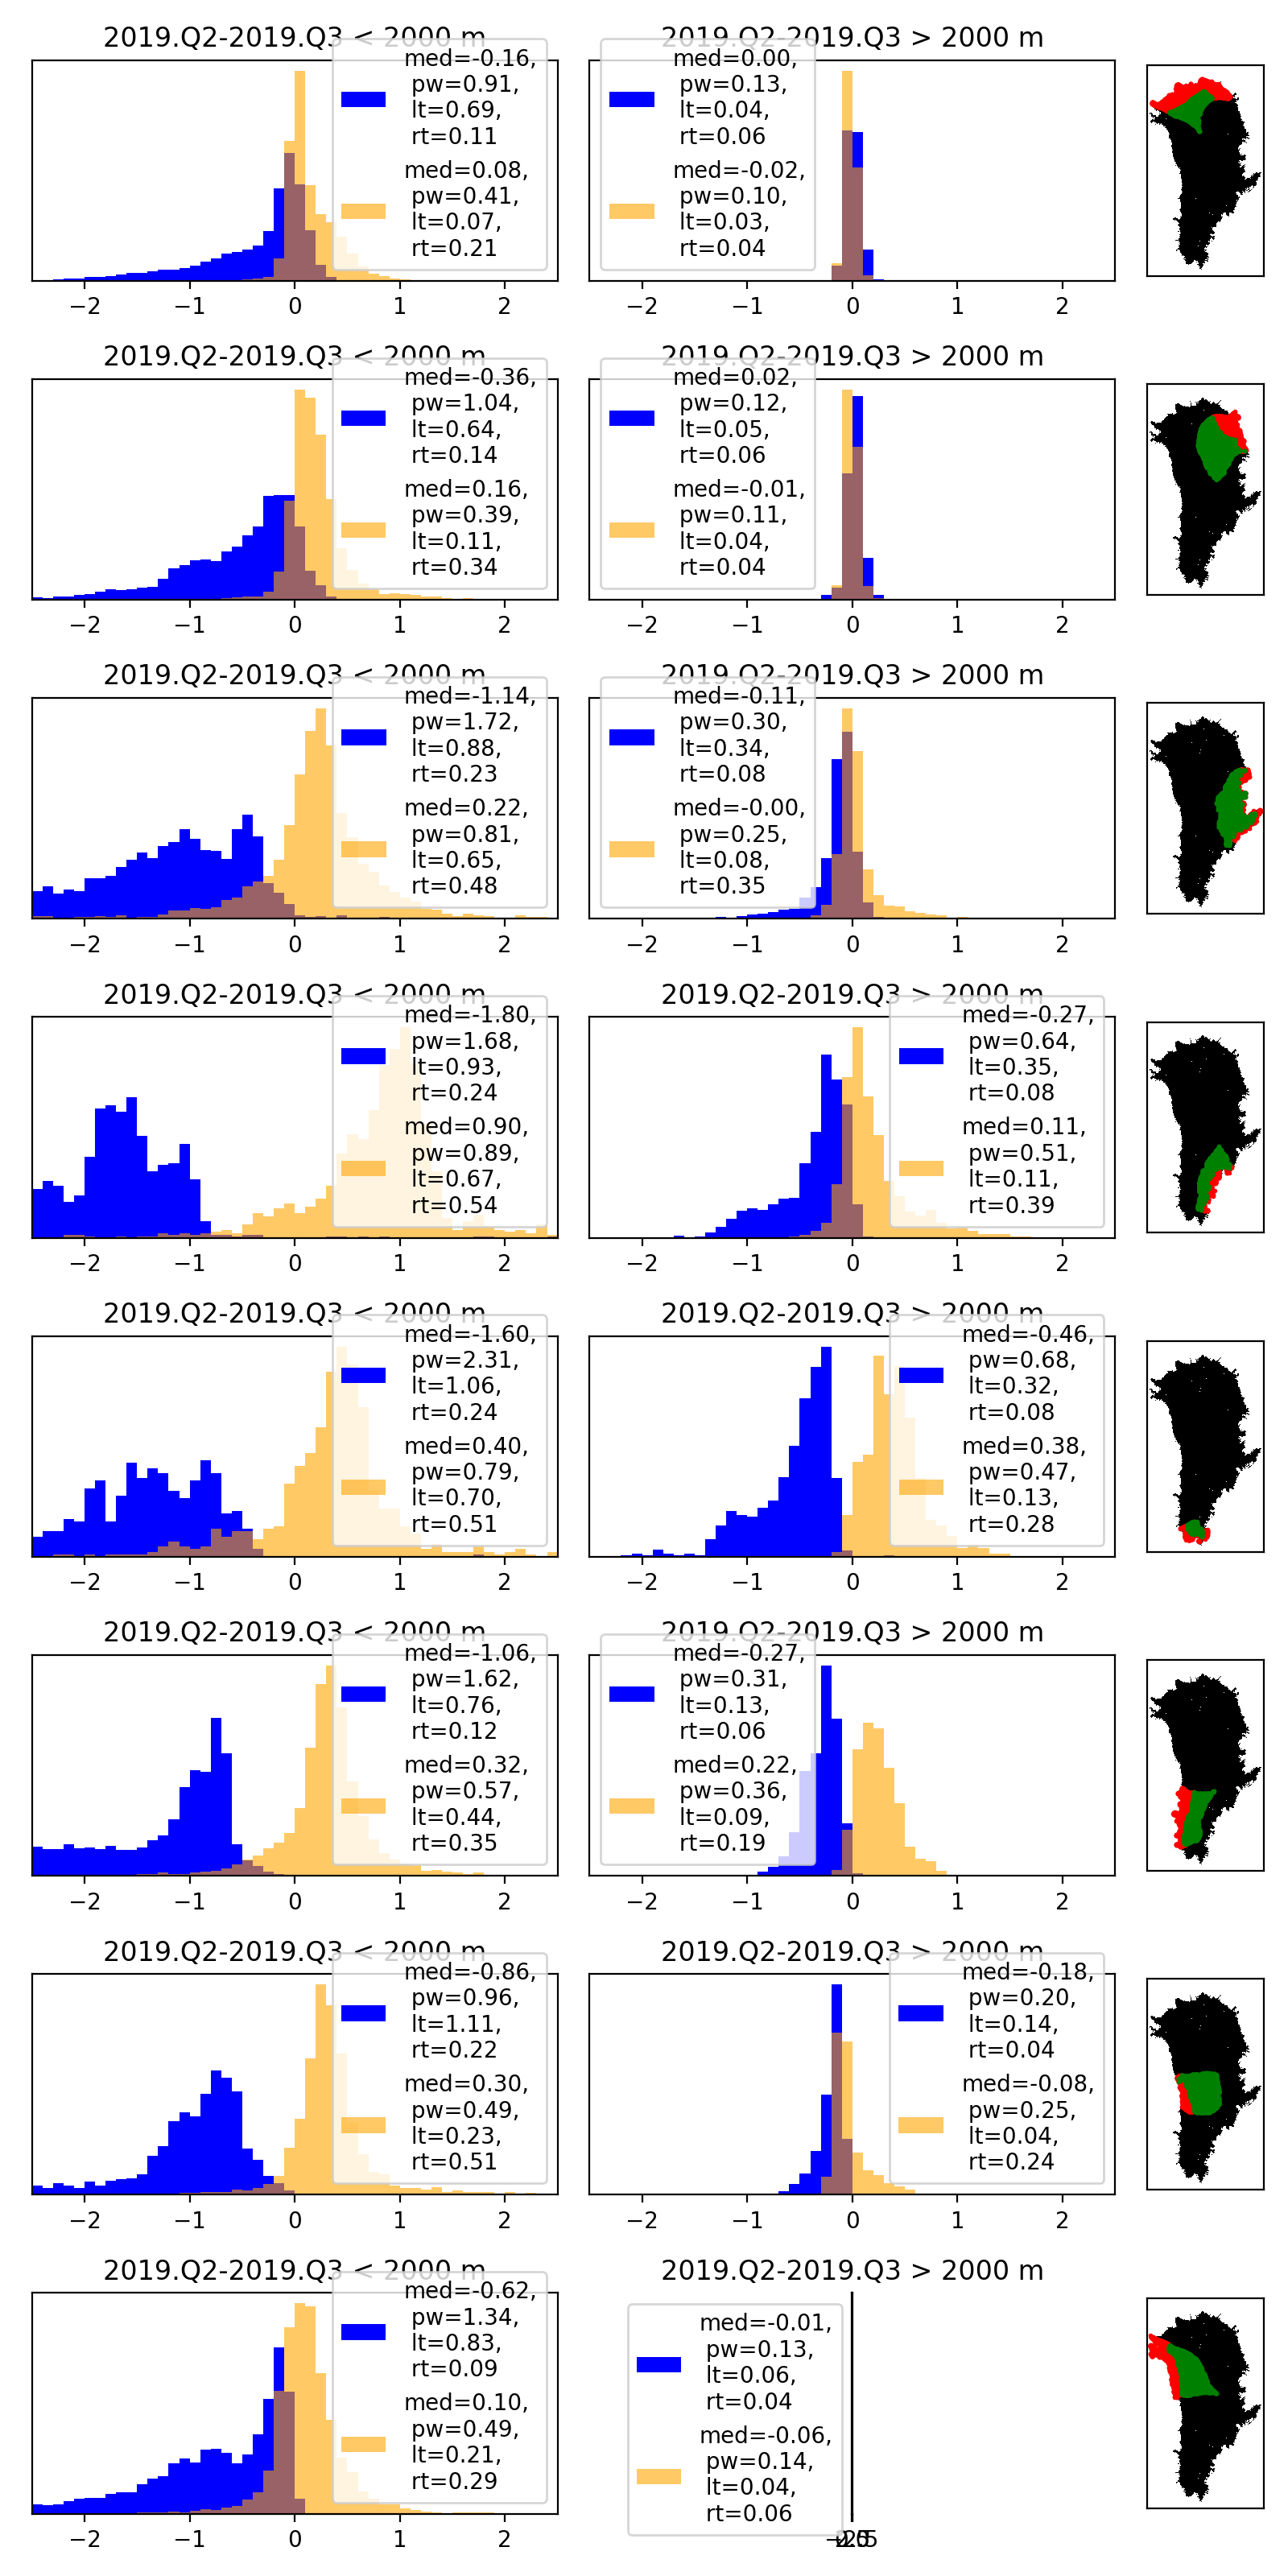

/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [5]:
epoch=epochs[2]
model=models[1]

dh_bins=np.arange(-2.5, 2.5, 0.05)
NaN_mask=np.zeros_like(drainage_basins.z)+np.NaN
NaN_mask[np.isfinite(drainage_basins.z)]=1

h_ranges=[(-10, 2000), (2000, 5000)]
h_range_cols={h_ranges[0]:0, h_ranges[1]:1}
h_range_colors={h_ranges[0]:'r', h_ranges[1]:'g'}
h_range_names=['< 2000', '> 2000']

basins=np.arange(1,9)

fig=plt.figure(4, figsize=[8, 16])#, constrained_layout=True)
fig.clf()
dh_bins=np.arange(-5, 5, 0.1)
h_spec=plt.figure(4).add_gridspec(nrows=len(basins), ncols=3, width_ratios=[.45, .45, .1])
hax=[[[], [], []] for basin in basins]

NaN_mask=np.zeros_like(drainage_basins.z)+np.NaN
NaN_mask[np.isfinite(drainage_basins.z)]=1

h_ranges=[(-10, 2000), (2000, 5000)]
h_range_cols={h_ranges[0]:0, h_ranges[1]:1}
h_range_colors={h_ranges[0]:'r', h_ranges[1]:'g'}
h_range_names=['< 2000', '> 2000']

basins=np.arange(1,9)
percentiles=np.array([5, 16, 50, 84, 95])
pct={key:{h_range:np.zeros((basins.size, percentiles.size)) for h_range in h_ranges} for key in ['raw','corr']}

for basin in basins:
    for h_range in h_ranges:
        hax[basin-1][2]=fig.add_subplot(h_spec[basin-1, 2])
        hax[basin-1][2].imshow(NaN_mask, extent=drainage_basins.extent, origin='lower', cmap='gray')
        Dsub=D[model][epoch]
        els = np.floor(Dsub.basin)==basin
        els &= (Dsub.h0 > h_range[0])
        els &= (Dsub.h0 < h_range[1])
        Dsub=D[model][epoch][els]
        
        pct['raw'][h_range][basin-1,:]=ss.scoreatpercentile(Dsub.dh, percentiles)
        temp=pct['raw'][h_range][basin-1,:]
        raw_label='med=%3.2f,\n pw=%3.2f,\n lt=%3.2f,\n rt=%3.2f'% (temp[2], temp[3]-temp[1], temp[1]-temp[0], temp[4]-temp[3])
         
        pct['corr'][h_range][basin-1,:]=ss.scoreatpercentile(Dsub.dh_corr, percentiles)
        temp=pct['corr'][h_range][basin-1,:]
        corr_label='med=%3.2f,\n pw=%3.2f,\n lt=%3.2f,\n rt=%3.2f'% (temp[2], temp[3]-temp[1], temp[1]-temp[0], temp[4]-temp[3])
        
        hax[basin-1][h_range_cols[h_range]]=fig.add_subplot(h_spec[basin-1, h_range_cols[h_range]])
        hist_ax=hax[basin-1][ h_range_cols[h_range]]
        hist_ax.hist(Dsub.dh, dh_bins, color='blue', label=raw_label)
        hist_ax.hist(Dsub.dh_corr, dh_bins, alpha=0.6, color='orange', label=corr_label)     
        hist_ax.legend()
        hax[basin-1][ 2].plot(Dsub.x, Dsub.y,'.', color=h_range_colors[h_range],  markersize=2)
        #xy=np.unique(np.round((Dsub.x[els]+1j*Dsub.y[els])/5.e3)*5.e3)
        
        #hax[basin-1][2].plot(np.real(xy), np.imag(xy),'.', color=h_range_colors[h_range],  markersize=2)
        
    hax[basin-1][2].set_xticks([])
    for ii in [0, 1, 2]:
        hax[basin-1][ii].set_yticks([])
    for ii in [0, 1]:
        hax[basin-1][ii].set_xlim(-2.5, 2.5)
    hax[basin-1][ 0].set_title(epoch+' < 2000 m')
    hax[basin-1][ 1].set_title(epoch+' > 2000 m')
plt.tight_layout()

### Calculate the percentiles for all models and for all epochs
We'll save the percentiles of the elevation differences for all the models to look at collectively

In [6]:
h_ranges=[(-10, 2000), (2000, 5000)]
h_range_cols={h_ranges[0]:0, h_ranges[1]:1}
h_range_colors={h_ranges[0]:'r', h_ranges[1]:'g'}
h_range_names=['< 2000', '> 2000']

basins=np.arange(1,9)

percentiles=np.array([5, 16, 50, 84, 95])
pct={epoch:\
     {model:\
      {h_range:\
       {rc:np.zeros((basins.size, percentiles.size)) for rc in ['raw', 'corr']}\
       for h_range in h_ranges}\
      for model in models}
     for epoch in epochs}

for count, model in enumerate(models): 
    for epoch in epochs:
        for basin in basins:
            for h_range in h_ranges: 
                Dsub=D[model][epoch]
                els = np.floor(Dsub.basin)==basin
                els &= (Dsub.h0 > h_range[0])
                els &= (Dsub.h0 < h_range[1])
                Dsub=Dsub[els]
                pct[epoch][model][h_range]['raw'][basin-1,:]=ss.scoreatpercentile(Dsub.dh, percentiles)
                pct[epoch][model][h_range]['corr'][basin-1,:]=ss.scoreatpercentile(Dsub.dh_corr, percentiles)
               

### Tables of statistics:
This function reports a summary of a particular statistic for the different models.

In [7]:
sn={'raw':'raw',
        'GSFC_fdm_v1_zsurf':'GSFC_v1',
        'MARv3_11_ERA_zsurf':'M3.11ERA.15', 
        'MARv3_11_2_ERA_10km_zsurf':'M3.11.2ERA10',
        'MARv3_11_2_ERA_20km_zsurf':'M3.11.2ERA20',
        'MARv3_11_2_NCEP_20km_zsurf':'M311.2NC20'
        ''}
sigma_sn={model:f'$\sigma_{{{sn[model]}}}$' for model in sn.keys()}


In [8]:
def all_basin_stats(pct, epoch, h_range, var):
    if var=='lt_tail':
        p1=1
        p0=0
    elif var == 'ctr':
        p1=3
        p0=1
    elif var == 'rt_tail':
        p1=4
        p0=3

    models=['GSFC_fdm_v1_zsurf', 'MARv3_11_ERA_zsurf', 'MARv3_11_2_ERA_10km_zsurf',
     'MARv3_11_2_ERA_20km_zsurf',
     'MARv3_11_2_NCEP_20km_zsurf']
    
    #short names

    sigma_sn={model:f'$\sigma_{{{sn[model]}}}$' for model in sn.keys()}
        
    column_list=['basin','raw', sigma_sn['raw']]
    for model in models:
        column_list += [sn[model]]
        column_list += [sigma_sn[model]]

    df={var:np.zeros(len(basins)) for var in column_list}
    df['basin']=np.arange(len(basins), dtype=int)+1
    
    # first two lines give  model, and resolution
    str1='basin\t raw'
    str2='\t \t'
    for model in models:
        m=re.compile('(.*)_(..km)_zsurf').search(model)
        if m is not None:
            str1 += f'\t {m.group(1)}'
            str2 += f'\t {m.group(2)}'
        else:
            str1 += f'\t {model.replace("_zsurf","")}'
            str2 += '\t 15km'              

    print(f'{epoch}\t{h_range[0]} m to {h_range[1]} m, {var}')
    #print(str1)
    #print(str2)
    # remaining lines give basin, range center, and range spread
    for basin in basins:
        raw=pct[epoch][models[1]][h_range]['raw'][basin-1,:]
        thestr=f'{basin}:\t {0.5*(raw[ p1]+raw[p0]):2.3f}({(raw[ p1]-raw[p0]):2.3f})'
        df['raw'][basin-1]=0.5*(raw[ p1]+raw[p0])
        df[sigma_sn['raw']][basin-1]=(raw[ p1]-raw[p0])
        for model in models:        
            corr=pct[epoch][model][h_range]['corr'][basin-1,:]
            thestr += f' \t{0.5*(corr[p1]-corr[p0]):2.3f}({(corr[p1]-corr[p0]):2.3f})'
            df[sn[model]][basin-1]=0.5*(corr[p1]-corr[p0])
            df[sigma_sn[model]][basin-1]=corr[p1]-corr[p0]                  
        #print(thestr)
    #df=pd.DataFrame(df)
    #df=df[columns]
    df=pd.DataFrame(df)[column_list]
    return df
    


In [9]:
def highlight_minabs(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = np.abs(data) == np.abs(data).min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == np.abs(data).min().min()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [10]:
def bold_abs_lt_first(data):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr_good = 'font-weight: bold' 
    attr_bad = 'color : red'
    is_lt = np.abs(data) < np.abs(data[0])
    temp = [attr_good if v else attr_bad for v in is_lt]
    temp[0] = ''
    return temp
    

## Center statistics: Central peak
Look at the width of the central peak for two epochs.  

#### Epoch 1 (Q4 of 2018 to Q2 of 2019), low elevation:

In [11]:
df=all_basin_stats(pct, epochs[0], h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2018.Q4-2019.Q2	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.034,0.19,0.082,0.16,0.11,0.23,0.12,0.24,0.11,0.23,0.12,0.24
1,2,-0.052,0.27,0.1,0.21,0.13,0.27,0.14,0.28,0.14,0.27,0.14,0.28
2,3,0.13,0.65,0.29,0.58,0.34,0.67,0.34,0.68,0.34,0.67,0.32,0.65
3,4,1.3,1.9,0.51,1,0.97,1.9,0.95,1.9,0.96,1.9,1.1,2.2
4,5,1.3,2.1,0.61,1.2,0.98,2,0.89,1.8,0.93,1.9,0.9,1.8
5,6,0.28,0.76,0.27,0.53,0.47,0.94,0.48,0.96,0.48,0.96,0.48,0.97
6,7,-0.049,0.59,0.28,0.57,0.4,0.79,0.41,0.81,0.4,0.79,0.45,0.9
7,8,-0.22,0.38,0.19,0.39,0.25,0.5,0.25,0.5,0.25,0.49,0.29,0.58


#### Epoch 1 (Q4 of 2018 to Q2 of 2019), low elevation:

In [12]:
df=all_basin_stats(pct, epochs[0], h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2018.Q4-2019.Q2	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.098,0.087,0.038,0.075,0.051,0.1,0.055,0.11,0.052,0.1,0.063,0.13
1,2,-0.094,0.087,0.043,0.086,0.048,0.095,0.051,0.1,0.048,0.095,0.053,0.11
2,3,-0.096,0.19,0.085,0.17,0.14,0.29,0.15,0.3,0.15,0.3,0.14,0.27
3,4,0.22,0.58,0.16,0.33,0.5,0.99,0.48,0.96,0.55,1.1,0.52,1
4,5,-0.005,0.49,0.2,0.4,0.55,1.1,0.53,1.1,0.53,1.1,0.54,1.1
5,6,-0.07,0.25,0.096,0.19,0.14,0.29,0.15,0.31,0.15,0.3,0.14,0.27
6,7,-0.085,0.18,0.066,0.13,0.11,0.22,0.11,0.23,0.11,0.22,0.14,0.29
7,8,-0.1,0.14,0.057,0.11,0.098,0.2,0.099,0.2,0.1,0.2,0.12,0.23


#### Epoch 2: (Q1 of 2019 to Q2 of 2019), at high elevation:

In [13]:
df=all_basin_stats(pct, epochs[1], h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q1-2019.Q2	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.054,0.086,0.04,0.081,0.049,0.098,0.052,0.1,0.049,0.099,0.058,0.12
1,2,-0.055,0.089,0.044,0.088,0.046,0.092,0.047,0.095,0.046,0.091,0.048,0.097
2,3,-0.072,0.17,0.078,0.16,0.11,0.22,0.11,0.22,0.11,0.23,0.11,0.22
3,4,0.081,0.43,0.12,0.24,0.35,0.71,0.33,0.65,0.36,0.72,0.38,0.77
4,5,0.084,0.67,0.19,0.38,0.35,0.69,0.36,0.72,0.33,0.67,0.29,0.58
5,6,-0.12,0.22,0.066,0.13,0.12,0.23,0.12,0.24,0.11,0.23,0.12,0.24
6,7,-0.097,0.18,0.061,0.12,0.099,0.2,0.1,0.2,0.095,0.19,0.11,0.23
7,8,-0.055,0.11,0.049,0.099,0.074,0.15,0.077,0.15,0.073,0.15,0.083,0.17


GSFC seems to have done the best job in reducing the model spread.  There isn't a substantial winner here among the MAR models.  The higher resolution models (MAR_v311_ERA @ 15km and Mar_v311.2 @ 10km) have smaller spreads in a few basins, but the differences are small. The corrections also don't seem to capture a large share of the variance in the data (spreads are comparable between raw and corrected data)

#### Epoch 3: (Q2 of 2019 to Q3 of 2019), at low elevation:

In [14]:
df=all_basin_stats(pct, epochs[2], h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q2-2019.Q3	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.4,0.91,0.24,0.47,0.19,0.39,0.21,0.41,0.21,0.43,0.25,0.49
1,2,-0.55,1,0.28,0.57,0.18,0.36,0.19,0.39,0.18,0.37,0.2,0.4
2,3,-1.3,1.7,0.4,0.81,0.42,0.84,0.4,0.81,0.44,0.87,0.44,0.89
3,4,-2.1,1.7,0.31,0.62,0.52,1,0.45,0.89,0.44,0.88,0.45,0.9
4,5,-2,2.3,0.67,1.3,0.46,0.91,0.39,0.79,0.42,0.84,0.44,0.88
5,6,-1.5,1.6,0.64,1.3,0.29,0.58,0.28,0.57,0.3,0.6,0.27,0.54
6,7,-1,0.96,0.33,0.67,0.24,0.48,0.25,0.49,0.25,0.5,0.23,0.46
7,8,-0.8,1.3,0.34,0.69,0.23,0.47,0.25,0.49,0.26,0.51,0.28,0.57


Here the corrections seem to both make large reductions in the spread of the signal, and seem to correct for the large drawdown signals.  The statistics are similar across the models, although the v3.11.2 models seem to have modestly better spread than the V3.11 model, and the 10km v3.11.2 is better than the coarser resolution version.


## Tail statistics: Left-hand tail
Look at the width of the central peak for two epochs.  

#### Epoch 2: (Q1 of 2019 to Q2 of 2019), at low elevation:

In [15]:
df=all_basin_stats(pct, epochs[1], h_ranges[0],'lt_tail')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q1-2019.Q2	-10 m to 2000 m, lt_tail


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.12,0.062,0.039,0.077,0.032,0.064,0.032,0.065,0.032,0.065,0.033,0.065
1,2,-0.22,0.14,0.05,0.1,0.04,0.081,0.041,0.081,0.04,0.08,0.037,0.074
2,3,-0.51,0.46,0.23,0.46,0.25,0.5,0.25,0.51,0.25,0.51,0.28,0.57
3,4,-0.28,0.65,0.28,0.57,0.34,0.69,0.35,0.7,0.42,0.83,0.25,0.5
4,5,-0.44,0.19,0.13,0.26,0.25,0.5,0.21,0.42,0.26,0.53,0.14,0.29
5,6,-0.36,0.24,0.063,0.13,0.062,0.12,0.065,0.13,0.074,0.15,0.07,0.14
6,7,-0.5,0.24,0.11,0.22,0.1,0.2,0.099,0.2,0.094,0.19,0.087,0.17
7,8,-0.35,0.19,0.12,0.25,0.078,0.16,0.076,0.15,0.072,0.14,0.079,0.16


There isn't a substantial winner here.  The higher resolution models (MAR_v311_ERA @ 15km and Mar_v311.2 @ 10km) have smaller spreads in a few basins, but the differences are small. The corrections also don't seem to capture a large share of the variance in the data (spreads are comparable between raw and corrected data)

#### Epoch 3: (Q2 of 2019 to Q3 of 2019), at low elevation:

In [16]:
df=all_basin_stats(pct, epochs[2], h_ranges[0],'lt_tail')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q2-2019.Q3	-10 m to 2000 m, lt_tail


,basin,raw,$\sigma_{raw}$,GSFC_v1,$\sigma_{GSFC_v1}$,M3.11ERA.15,$\sigma_{M3.11ERA.15}$,M3.11.2ERA10,$\sigma_{M3.11.2ERA10}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-1.2,0.69,0.15,0.31,0.037,0.075,0.034,0.067,0.033,0.066,0.037,0.074
1,2,-1.4,0.62,0.16,0.32,0.074,0.15,0.056,0.11,0.059,0.12,0.046,0.091
2,3,-2.6,0.88,0.33,0.66,0.33,0.66,0.32,0.65,0.36,0.72,0.36,0.72
3,4,-3.4,0.93,0.26,0.52,0.31,0.62,0.33,0.67,0.32,0.63,0.3,0.6
4,5,-3.7,1.1,0.39,0.78,0.35,0.7,0.35,0.7,0.33,0.66,0.38,0.75
5,6,-2.7,0.76,0.27,0.53,0.22,0.44,0.22,0.44,0.2,0.4,0.21,0.41
6,7,-2.1,1.1,0.41,0.81,0.12,0.25,0.12,0.23,0.12,0.24,0.12,0.23
7,8,-1.9,0.83,0.28,0.56,0.11,0.22,0.11,0.21,0.077,0.15,0.094,0.19


# deeper dive into individual drainage basins: basin 1

In [144]:
basin=1
h_range=h_ranges[1]
h_bins=np.arange(-2, 2.01, 0.01)
dh_hist={}
dist_data={}
for model in models:
    dh_hist[model]={ver:np.zeros((len(h_bins)-1, len(epochs))) for ver in ['raw','corr']}
    dh_hist[model].update({ver:np.zeros(len(epochs)) for ver in ['raw_med', 'corr_med']})
    dh_hist[model]['raw_data']={}
    dh_hist[model]['corr_data']={}
    for col, epoch in enumerate(epochs):
        Dsub=D[model][epoch]
        els = np.floor(Dsub.basin)==basin
        els &= (Dsub.h0 > h_range[0])
        els &= (Dsub.h0 < h_range[1])
        Dsub=Dsub[els]
        dh_hist[model]['raw_med'][col] = np.median(Dsub.dh)
        dh_hist[model]['corr_med'][col] = np.median(Dsub.dh_corr)
        dh_hist[model]['raw'][:, col] = np.histogram(Dsub.dh, bins=h_bins, density=True)[0]
        dh_hist[model]['corr'][:, col] = np.histogram(Dsub.dh_corr, bins=h_bins, density=True)[0]
        dh_hist[model]['raw_data'][epoch]=Dsub.dh[np.abs(Dsub.dh)<2.5]
        dh_hist[model]['corr_data'][epoch]=Dsub.dh_corr[np.abs(Dsub.dh_corr)<2.5]

<IPython.core.display.Javascript object>


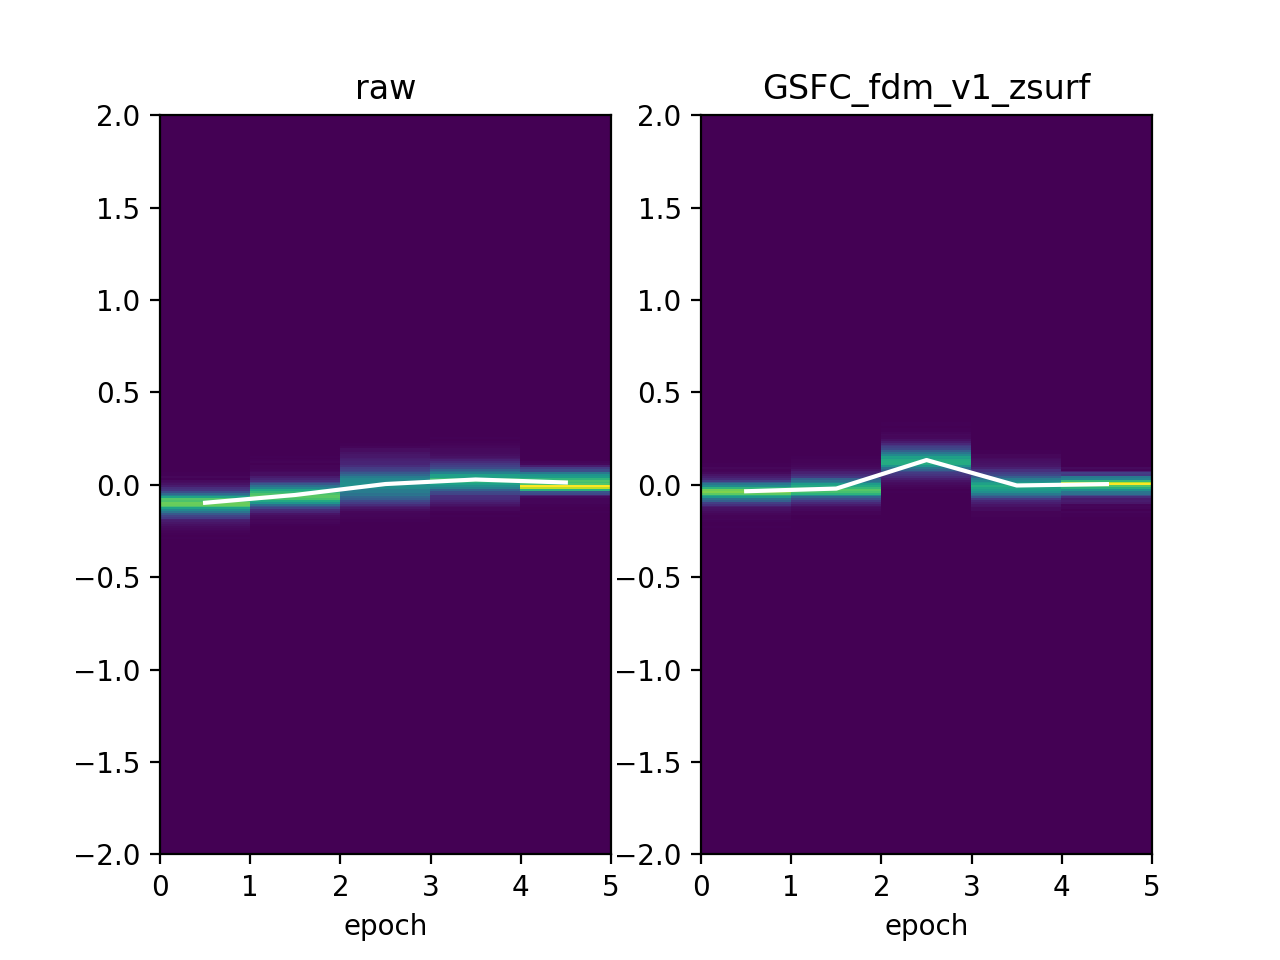

Text(0.5, 0, 'epoch')

In [147]:
model=models[0]
plt.figure(5); plt.clf()
plt.subplot(121)
plt.pcolor(np.arange(0, 6), h_bins, dh_hist[model]['raw'])
plt.plot(np.arange(0.5, 5.5), dh_hist[model]['raw_med'],'w')
plt.title('raw')
plt.xlabel('epoch')
plt.subplot(122)
plt.pcolor(np.arange(0, 6), h_bins, dh_hist[model]['corr'])
plt.plot(np.arange(0.5, 5.5), dh_hist[model]['corr_med'],'w')
plt.title(model)
plt.xlabel('epoch')

Not a satisfactory way to show the distributions, because the spread-out histograms are hard to see.

<IPython.core.display.Javascript object>


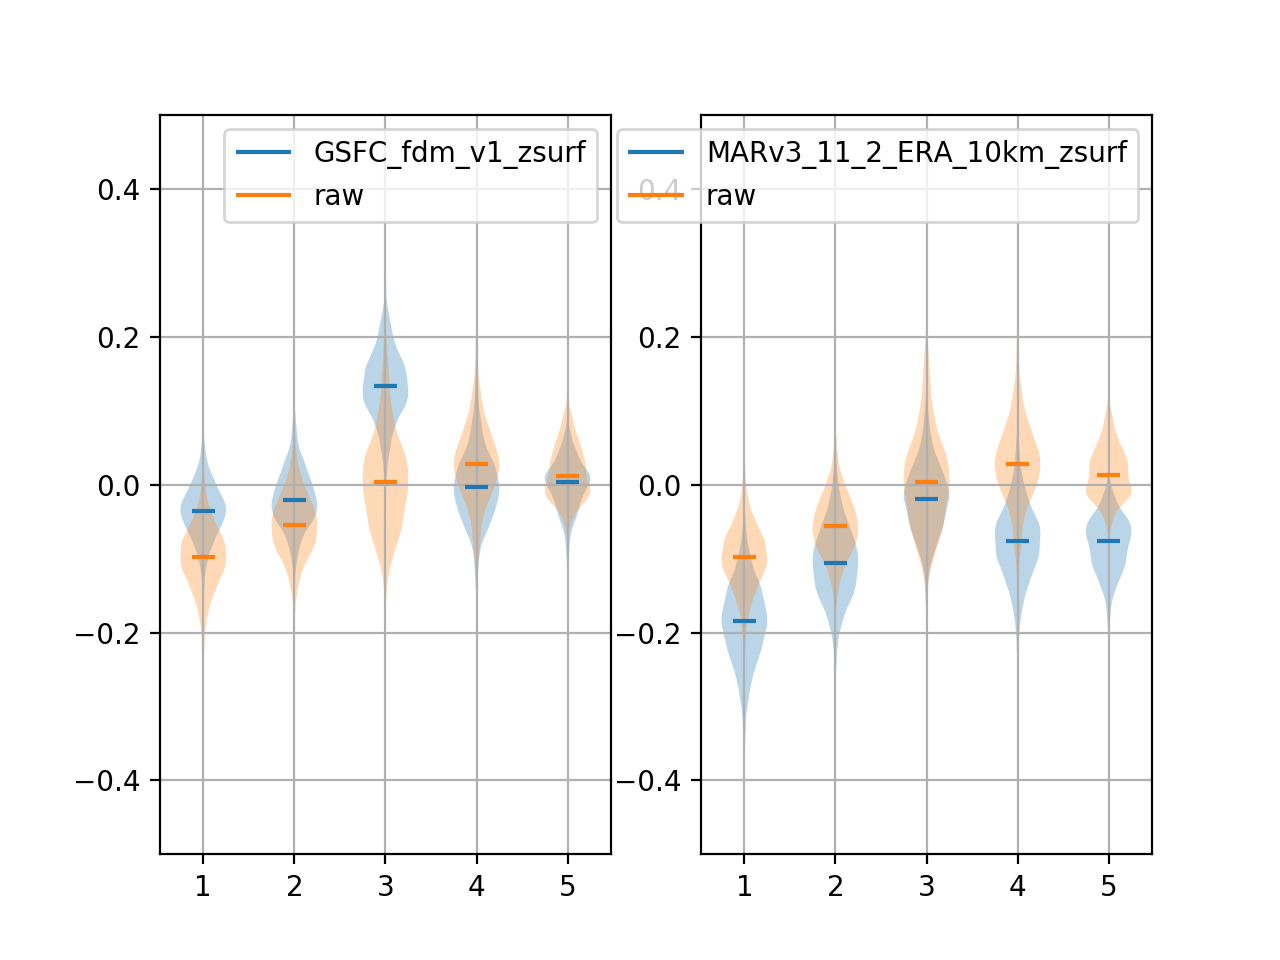

In [155]:
model=models[0]
fig=plt.figure(6); plt.clf()
fig.add_subplot(121)
d_corr=plt.violinplot([dh_hist[model]['corr_data'][epoch] for epoch in epochs],showextrema=False,  points=250, vert=True, showmedians=True)
d_corr['cmedians'].set_label(model)
d_raw=plt.violinplot([dh_hist[model]['raw_data'][epoch] for epoch in epochs],showextrema=False,  points=250, vert=True, showmedians=True)
d_raw['cmedians'].set_label('raw')
plt.gca().set_ylim([-0.5, 0.5])
plt.grid()
plt.legend();

model=models[1]
fig.add_subplot(122)
d_corr=plt.violinplot([dh_hist[model]['corr_data'][epoch] for epoch in epochs],showextrema=False,  points=250, vert=True, showmedians=True)
d_corr['cmedians'].set_label(model)
d_raw=plt.violinplot([dh_hist[model]['raw_data'][epoch] for epoch in epochs],showextrema=False,  points=250, vert=True, showmedians=True)
d_raw['cmedians'].set_label('raw')
plt.gca().set_ylim([-0.5, 0.5])
plt.grid()
plt.legend();


This is a nicer way to compare two different models.  There's another version of violinplot that comes up on Google that puts one distribution on the left of each bar and one on the right.  Might be worth exploring.